# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


# Setup

Make sure the files are available in the current directory. On Colab, upload them using the files tab on the left.

In [ ]:
#upload files to google collab
from google.colab import files
files.upload()

In [ ]:
!ls *.csv # List files to check train, ss and test are present

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

In [ ]:
# The training data.
train = pd.read_csv('Train.csv')
train.head()


,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,1692,1861,0,211,317,2493,111,141,413.474762,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,1859,1867,0,211,318,2497,112,138,429.034543,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,1677,1861,0,208,317,2486,109,141,477.246432,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,1061,1864,0,196,303,2333,98,124,646.388681,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,1714,1852,0,204,314,2426,109,145,582.340637,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [ ]:
# viewing summary info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83148 entries, 0 to 83147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             83148 non-null  object 
 1   lat            83148 non-null  float64
 2   lon            83148 non-null  float64
 3   burn_area      83148 non-null  float64
 4   climate_aet    83148 non-null  int64  
 5   climate_def    83148 non-null  int64  
 6   climate_pdsi   83148 non-null  int64  
 7   climate_pet    83148 non-null  int64  
 8   climate_pr     83148 non-null  int64  
 9   climate_ro     83148 non-null  int64  
 10  climate_soil   83148 non-null  int64  
 11  climate_srad   83148 non-null  int64  
 12  climate_swe    83148 non-null  int64  
 13  climate_tmmn   83148 non-null  int64  
 14  climate_tmmx   83148 non-null  int64  
 15  climate_vap    83148 non-null  int64  
 16  climate_vpd    83148 non-null  int64  
 17  climate_vs     83148 non-null  int64  
 18  elevat

In [ ]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('Test.csv')
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,1974,0,217,303,2481,99,148,413.474762,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


# EDA + Feature Engineering

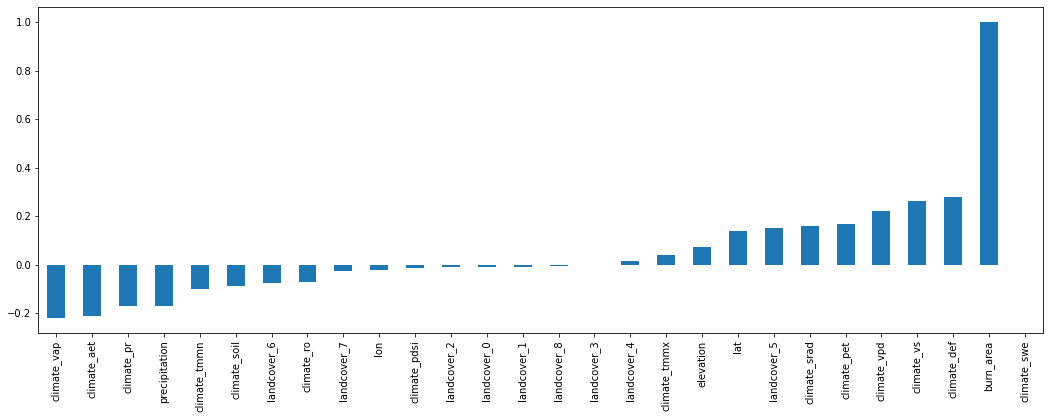

In [ ]:
# Look at correlation with target
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

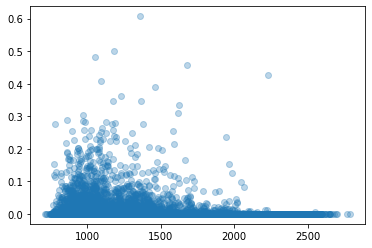

In [ ]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

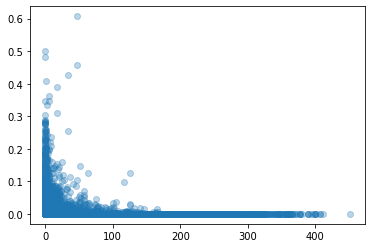

In [ ]:
# Most fires occur when there's very little rain.
plt.scatter(sample['climate_pr'], sample['burn_area'], alpha=0.3)

##  Adding date features

In [ ]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1])) 
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1])) 

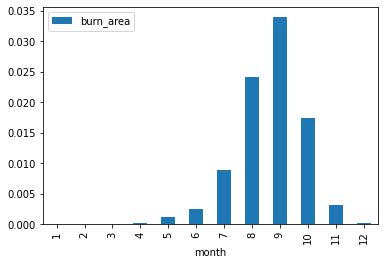

In [ ]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
train.groupby('month').mean().reset_index().plot(y='burn_area', x='month', kind='bar')

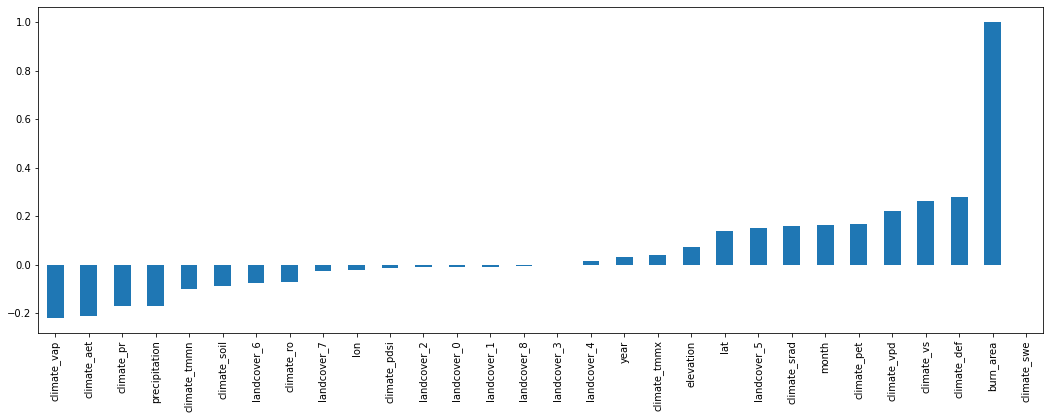

In [ ]:
# Look at correlation with target
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

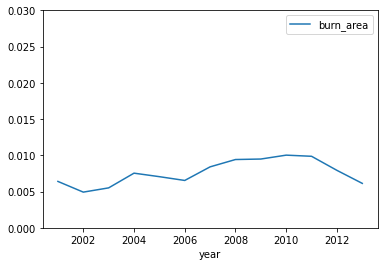

In [ ]:
# Plot trend year-on-year
train.groupby('year').mean().reset_index().plot(y='burn_area', x='year', ylim=(0, 0.03))

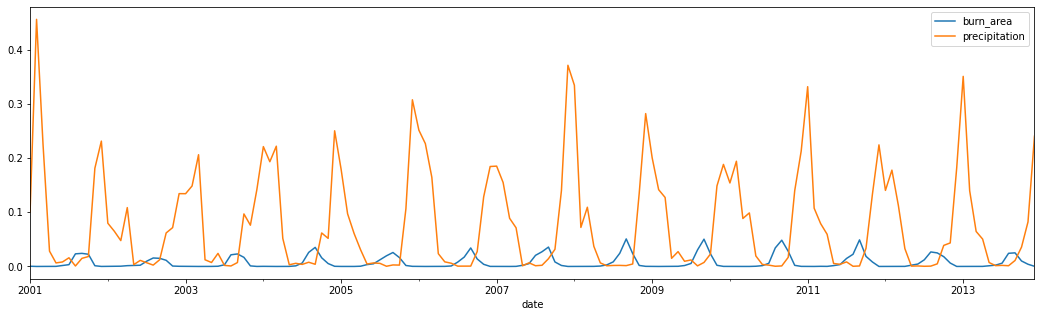

In [ ]:
# Let's plot precipitation and burn area on the same plot - note the strong periodic component to both.
ax = train.groupby('date').mean().reset_index().plot(y='burn_area', x='date', figsize=(18, 5))
train.groupby('date').mean().reset_index().plot(y='precipitation', x='date', ax=ax)

## Adding more features - some ideas




*   Read the list of climate variables and what they mean. See if you can combine them in interesting ways - perhaps a 'hot_and_dry' metric...
*   Fire depends on some processes that take a long time - for example, there may be more fuel if the previous growing season was a good one. Consider some lagged variables to give the model some inputs for what came before the current month.
*   Make some categorical features - 'dominant_land_type' or 'is_peak_rainfall'. 
*   ...



# Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [ ]:
import numpy as np
from datetime import datetime
train_all = train.copy().dropna()
train_all.info()
# train_all = np.array(train_all)
# for i in range(0, len(train_all[0])):
#   if isinstance(train_all[0, i], datetime.date):
#     continue
#   minX = min(train_all[:, i])
#   maxX = max(train_all[:, i])
#   train_all[:, i] = (train_all[:, i] - minX) / (maxX - minX)

train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']

       
print(train.shape, valid.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63960 entries, 0 to 63959
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             63960 non-null  object        
 1   lat            63960 non-null  float64       
 2   lon            63960 non-null  float64       
 3   burn_area      63960 non-null  float64       
 4   climate_aet    63960 non-null  int64         
 5   climate_def    63960 non-null  int64         
 6   climate_pdsi   63960 non-null  int64         
 7   climate_pet    63960 non-null  int64         
 8   climate_pr     63960 non-null  int64         
 9   climate_ro     63960 non-null  int64         
 10  climate_soil   63960 non-null  int64         
 11  climate_srad   63960 non-null  int64         
 12  climate_swe    63960 non-null  int64         
 13  climate_tmmn   63960 non-null  int64         
 14  climate_tmmx   63960 non-null  int64         
 15  climate_vap    6396

TypeError: ignored

AttributeError: ignored

In [ ]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [ ]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
import statsmodels.api as sm
included_features = forward_regression(X_train,y_train,0.05,False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [ ]:
X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]
# added_features = forward_regression(X_train,y_train,0.05)

# Simple Model

In [ ]:
# Define input and output columns - you can play with adding or removing inputs to the model
in_cols = ['climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'month', 'year', 'lat', 'lon']
target_col = 'burn_area'
len(in_cols)

29

In [ ]:
# Define input and output columns - you can play with adding or removing inputs to the model
in_cols = added_features
target_col = 'burn_area'
print(in_cols)

['climate_vap', 'climate_tmmx', 'climate_pet', 'lat', 'landcover_5', 'lon', 'year', 'climate_ro', 'climate_srad', 'landcover_7', 'elevation', 'precipitation', 'month', 'climate_tmmn', 'climate_vs', 'climate_pr', 'climate_aet', 'climate_pdsi', 'landcover_8', 'landcover_2', 'climate_soil', 'landcover_0', 'climate_def', 'climate_vpd']


In [ ]:
len(in_cols)

29

In [ ]:
# Exercise. Try a RandomForestRegressor model. Use n_estimators=10 if the default takes too long to run, and experiment with the max_depth parameter.

In [ ]:
# Get our X and y training and validation sets ready

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV


In [ ]:
# create array of models to evaluate
models = []
'''
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('RidgeCV', RidgeCV()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=10)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=10)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))
'''
models.append(('CatBoost',CatBoostRegressor(depth=10)))


parameters = {'depth'         : [10],
                 'learning_rate' : [0.1],
                 'iterations'    : [100],
           'border_count':[35, 40, 45, 50, 55],
                }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)   

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")   
  
print("\n The best estimator across ALL searched params:\n",
         grid.best_estimator_)
  
print("\n The best score across ALL searched params:\n",
         grid.best_score_)
  
print("\n The best parameters across ALL searched params:\n",
         grid.best_params_)

predictions = model.predict(X_valid)

score = mean_squared_error(y_valid, predictions)**0.5
    
# Evaluate the model
print("CATBOOST " , str(score))



# Evaluations
results = []
names = []
scoring = []
'''
for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    # Evaluate the model
    score = mean_squared_error(y_valid, predictions)**0.5

    results.append(score)
    names.append(name)
    
    msg = "%s: %f " % (name, score)
    print(msg)
    '''

0:	learn: 0.0285114	total: 52.8ms	remaining: 5.23s
1:	learn: 0.0278451	total: 98.7ms	remaining: 4.84s
2:	learn: 0.0272447	total: 144ms	remaining: 4.66s
3:	learn: 0.0266894	total: 189ms	remaining: 4.54s
4:	learn: 0.0262125	total: 234ms	remaining: 4.45s
5:	learn: 0.0258008	total: 285ms	remaining: 4.46s
6:	learn: 0.0254214	total: 330ms	remaining: 4.38s
7:	learn: 0.0250926	total: 375ms	remaining: 4.32s
8:	learn: 0.0247848	total: 421ms	remaining: 4.25s
9:	learn: 0.0245383	total: 466ms	remaining: 4.2s
10:	learn: 0.0242912	total: 515ms	remaining: 4.17s
11:	learn: 0.0240856	total: 560ms	remaining: 4.11s
12:	learn: 0.0239052	total: 605ms	remaining: 4.05s
13:	learn: 0.0237050	total: 650ms	remaining: 3.99s
14:	learn: 0.0235467	total: 695ms	remaining: 3.94s
15:	learn: 0.0233835	total: 742ms	remaining: 3.9s
16:	learn: 0.0231973	total: 787ms	remaining: 3.84s
17:	learn: 0.0230408	total: 834ms	remaining: 3.8s
18:	learn: 0.0228855	total: 879ms	remaining: 3.75s
19:	learn: 0.0227638	total: 926ms	remainin

'\nfor name, model in models:\n    # Fit the model\n    model.fit(X_train, y_train)\n    \n    predictions = model.predict(X_valid)\n    \n    # Evaluate the model\n    score = mean_squared_error(y_valid, predictions)**0.5\n\n    results.append(score)\n    names.append(name)\n    \n    msg = "%s: %f " % (name, score)\n    print(msg)\n    '

In [ ]:
X_valid

,precipitation,lat,climate_vap,landcover_5,year,climate_srad,elevation,climate_pr,landcover_7,climate_tmmn,climate_vs,climate_ro,month,climate_aet


In [ ]:
# Evaluate the model
print("CATBOOST " , str(score))

CATBOOST  0.021041430139979764


# Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [ ]:
# And the test data
test.head()

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date,month,year
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,1974,0,217,303,2481,99,148,413.474762,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243,2014-01-01,1,2014
1,1_2014-01-01,-15.858835,29.487029,1118,98,-405,1216,117,6,330,1973,0,216,304,2481,100,143,429.034543,0.0,0.000000,0.000000,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489,2014-01-01,1,2014
2,2_2014-01-01,-15.858835,29.737029,1067,137,-468,1204,111,6,194,1958,0,214,302,2465,97,143,477.246432,0.0,0.000000,0.000000,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122,2014-01-01,1,2014
3,3_2014-01-01,-15.858835,29.987029,969,187,-533,1156,101,5,78,1954,0,202,290,2317,88,122,646.388681,0.0,0.000000,0.000000,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596,2014-01-01,1,2014
4,4_2014-01-01,-15.858835,30.237029,927,270,-505,1197,96,5,139,1939,0,210,301,2412,99,143,582.340637,0.0,0.000000,0.000000,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100,2014-01-01,1,2014


In [ ]:
# Using all data for train
X_train, y_train = train_all[in_cols], train_all[target_col]

# model chosen
model = CatBoostRegressor(depth = 10, iterations = 100, learning_rate = 0.1, border_count = 32, grow_policy='Depthwise')

model.fit(X_train, y_train)

# Look at the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# So we need to predict the burn area for each row in test. 

# Add the same features to test as we did to train:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

# Get predictions
preds = model.predict(test[in_cols].fillna(0)) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
#ss['Prediction'] = preds
ss['burn_area'] = preds

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
#ss['Prediction'] = ss['Prediction'].clip(0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

0:	learn: 0.0284877	total: 96.2ms	remaining: 9.53s
1:	learn: 0.0278339	total: 192ms	remaining: 9.4s
2:	learn: 0.0273211	total: 286ms	remaining: 9.24s
3:	learn: 0.0268012	total: 386ms	remaining: 9.27s
4:	learn: 0.0263197	total: 485ms	remaining: 9.21s
5:	learn: 0.0259621	total: 580ms	remaining: 9.09s
6:	learn: 0.0255935	total: 688ms	remaining: 9.14s
7:	learn: 0.0253001	total: 782ms	remaining: 8.99s
8:	learn: 0.0250388	total: 874ms	remaining: 8.84s
9:	learn: 0.0247529	total: 963ms	remaining: 8.66s
10:	learn: 0.0244920	total: 1.06s	remaining: 8.55s
11:	learn: 0.0243021	total: 1.15s	remaining: 8.43s
12:	learn: 0.0241170	total: 1.24s	remaining: 8.32s
13:	learn: 0.0239276	total: 1.34s	remaining: 8.25s
14:	learn: 0.0237715	total: 1.44s	remaining: 8.16s
15:	learn: 0.0236048	total: 1.54s	remaining: 8.06s
16:	learn: 0.0234381	total: 1.63s	remaining: 7.97s
17:	learn: 0.0232701	total: 1.73s	remaining: 7.87s
18:	learn: 0.0231767	total: 1.83s	remaining: 7.8s
19:	learn: 0.0230348	total: 1.92s	remainin

,ID,burn_area
0,0_2014-01-01,0.0
1,1_2014-01-01,0.0
2,2_2014-01-01,0.0
3,3_2014-01-01,0.0
4,4_2014-01-01,0.0


In [ ]:
# Save ready for submission:
ss.to_csv('drive/My Drive/zindi/28_submission.csv', index=False)

In [ ]:
ss.tail(20)

,ID,burn_area
25564,513_2017-12-01,0.000615
25565,514_2017-12-01,0.001683
25566,515_2017-12-01,0.000000
25567,516_2017-12-01,0.000000
25568,517_2017-12-01,0.000000
25569,518_2017-12-01,0.000000
25570,519_2017-12-01,0.000000
25571,520_2017-12-01,0.000000
25572,521_2017-12-01,0.002047
25573,522_2017-12-01,0.004264


# Tips for improving your score

- Once you've chosen a model, you should re-train it on all the data (including that which you previously held back for validation) to give it the best chance of succeeding
- There is a timeseries component to this challenge. Think about how to use this to improve your accuracy.
- Spend some time on feature engineering. Since no external data is allowed for this challenge, the winning solution will be the one that gets the most out of the data provided.